In [ ]:
pip install transformers

     |████████████████████████████████| 3.1 MB 13.2 MB/s 
     |████████████████████████████████| 3.3 MB 43.5 MB/s 
     |████████████████████████████████| 895 kB 69.2 MB/s 
     |████████████████████████████████| 596 kB 50.1 MB/s 
     |████████████████████████████████| 59 kB 6.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# All the imports!
import tensorflow as tf 
import numpy as np
from tensorflow.keras.preprocessing import sequence
from numpy import array

# Supress deprecation warnings
import logging
logging.getLogger('tensorflow').disabled = True

# Fetch "IMDB Movie Review" data, constraining our reviews to 
# the 10000 most commonly used words
vocab_size = 10000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)

# Map for readable classnames
class_names = ["Negative", "Positive"]

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
# Get the word index from the dataset
word_index = tf.keras.datasets.imdb.get_word_index()

# Ensure that "special" words are mapped into human readable terms 
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2
word_index["<UNUSED>"] = 3

# Perform reverse word lookup and make it callable
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1654784/1641221 [==============================] - 0s 0us/step


In [ ]:
def text_to_encodings(text):
    ar = []
    for i in text:
      if i in word_index:
        ar.append(word_index.get(i, '?'))
    return ar

In [ ]:
x_train_cut = x_train[:1000]
y_train_cut = y_train[:1000]
x_train_cut_list = x_train_cut.tolist()

In [ ]:
import random
random_ar = random.sample(range(0, 999), 100)

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

#English to German using the Pipeline and T5
translator_en_to_de = pipeline("translation_en_to_de", model='t5-base')

tokenizer = AutoTokenizer.from_pretrained("google/bert2bert_L-24_wmt_de_en", pad_token="<pad>", eos_token="</s>", bos_token="<s>")
model_de_to_en = AutoModelForSeq2SeqLM.from_pretrained("google/bert2bert_L-24_wmt_de_en")

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/2.88G [00:00<?, ?B/s]

In [ ]:
for i in random_ar:

    # convert the input text from embedding representation to human readable format
    input_text = decode_review(x_train_cut[i])
    print('Input Text -> ', input_text)

    # convert the input text from english to german 
    en_to_de_output = translator_en_to_de(input_text, max_length =5000)
    translated_text = en_to_de_output[0]['translation_text']
    print('Translated text -> ', translated_text)

    # convert the translated text from german to english 
    input_ids = tokenizer(translated_text, return_tensors="pt", add_special_tokens=False).input_ids
    output_ids = model_de_to_en.generate(input_ids)[0]
    augmented_text = tokenizer.decode(output_ids, skip_special_tokens=True)

    # add augmented data with label to our original train data points
    ar = text_to_encodings(augmented_text)
    x_train_cut_list.append(ar)
    y_train_cut = np.append(y_train_cut, y_train_cut[i])

Input Text ->  <START> the first episode immediately gave a good impression what to expect from the series mysteries waiting to be solved and a lot of good drama i love the fact that they gradually reveal the stories concerning the characters explaining just enough to stay excited of course this show has some flaws in the first two series there are some characters who for some reason don't show up in the third season many of the characters have a decent sent off but some of them just aren't there like rose and her husband where the hell are they what happened to them maybe they will return in later episodes but it is a little inconsistent that being said lost manages to be thrilling every episode especially the first two seasons that is a very hard thing to do i do notice that in the third season the focus is more on character development than the mystery aspects of the show this is not a bad thing it even saves some episodes from getting boring one of the elements that can be consider

Token indices sequence length is longer than the specified maximum sequence length for this model (625 > 512). Running this sequence through the model will result in indexing errors


Input Text ->  <START> rented a <UNKNOWN> of films from blockbuster last night and this was the first one i watched it was late on a saturday night wanted a horror film fix br br wow this was awful almost embarrassingly so stupid slasher type story i really thought films like scream had put an end to amateur actors delivering <UNKNOWN> and insipid dialogue that is hard to believe was actually <UNKNOWN> and read off a page and gore scenes that are nothing to get excited about especially when occurring in a film this poorly scripted br br but i've always believed no film is 100 percent totally worthless here's the few good things i can say about this mess br br 1 <UNKNOWN> phillips love this actress she's the only member of the cast who displays any acting talent whatsoever the only reason i took a chance on renting this is because her name was on the front cover she <UNKNOWN> her presence in this dreck with <UNKNOWN> even though she looks <UNKNOWN> at times that she's acting in such a m

In [ ]:
x_train_cut = np.array(x_train_cut_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
# The length of reviews
review_length = 500

# Padding / truncated our reviews
x_train_cut = sequence.pad_sequences(x_train_cut, maxlen = review_length)
x_test = sequence.pad_sequences(x_test, maxlen = review_length)

# Check the size of our datasets. Review data for both test and training should 
# contain 25000 reviews of 500 integers. Class data should contain 25000 values, 
# one for each review. Class values are 0 or 1, indicating a negative 
# or positive review.
print("Shape Training Review Data: " + str(x_train_cut.shape))
print("Shape Training Class Data: " + str(y_train_cut.shape))
print("Shape Test Review Data: " + str(x_test.shape))
print("Shape Test Class Data: " + str(y_test.shape))

# Note padding is added to start of review, not the end
print("")
print("Human Readable Review Text (post padding): " + decode_review(x_train_cut[60]))

Shape Training Review Data: (1016, 500)
Shape Training Class Data: (1016,)
Shape Test Review Data: (25000, 500)
Shape Test Class Data: (25000,)

Human Readable Review Text (post padding): <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

In [ ]:
model = tf.keras.models.Sequential()

model.add(
    tf.keras.layers.Embedding(
        input_dim = vocab_size, # The size of our vocabulary 
        output_dim = 32, # Dimensions to which each words shall be mapped
        input_length = review_length # Length of input sequences
    )
)

model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)

model.add(
    tf.keras.layers.GRU(
        units=32 # 32 GRU units in this layer
    )
)

model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)

model.add(
    tf.keras.layers.Dense(
        units=1, # Single unit
        activation='sigmoid' # Sigmoid activation function (output from 0 to 1)
    )
)

# Compile the model
model.compile(
    loss=tf.keras.losses.binary_crossentropy, # loss function
    optimizer=tf.keras.optimizers.Adam(), # optimiser function
    metrics=['accuracy']) # reporting metric

# Display a summary of the models structure
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 326,369
Trainable params: 326,369
Non-trainable params: 0
_________________________________________________________________


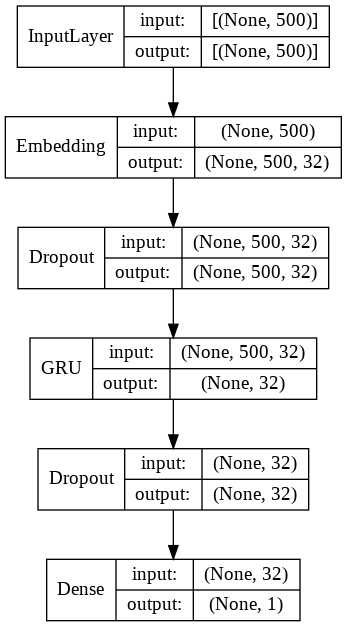

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [ ]:
# Train the GRU model on the training data
history = model.fit(

    x_train_cut, y_train_cut,
                    
    batch_size=32, 

    epochs=3, 

    validation_split=0.2,
    
    verbose=1
) 

Epoch 1/3
28/28 [==============================] - 6s 202ms/step - loss: 0.4145 - accuracy: 0.8337 - val_loss: 0.6250 - val_accuracy: 0.6712
Epoch 2/3
28/28 [==============================] - 6s 198ms/step - loss: 0.1668 - accuracy: 0.9480 - val_loss: 0.8105 - val_accuracy: 0.6441
Epoch 3/3
28/28 [==============================] - 5s 197ms/step - loss: 0.0925 - accuracy: 0.9819 - val_loss: 0.7727 - val_accuracy: 0.6982


In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
scores[1]

782/782 [==============================] - 25s 32ms/step - loss: 0.5458 - accuracy: 0.7643


0.7642800211906433